# Card Sorter

This notebook aims at showing our current progress on the software concerning the _Card Sorter_ for [Fantasia Store](https://fantasiastore.it/it/).

In [20]:
# %load hide_code.py

## Database download

We rely on the database [https://mtgjson.com/](https://mtgjson.com/) and download the images from [https://scryfall.com/](https://scryfall.com/) using the unique code provided by the database. This database contains all the main information about all the cards available in various languages and it is periodically updated.

<a href="https://mtgjson.com/downloads/all-files/"><img src="https://i.ibb.co/prwy3cz/mtgjson.png" alt="mtgjson" border="0"></a>

In [21]:
import os
import json
import requests

# General Variables
url_db = 'https://mtgjson.com/api/v5/AllPrintings.json'
saveLocation = './JSONs/AllPrintings.json'
force_download = False

# Variable used for the image download
image_id_wildcard = '${card.identifiers.scryfallId}'
image_url = 'https://api.scryfall.com/cards/${card.identifiers.scryfallId}?format=image' #lol

In [22]:
print("Current working Directory:", os.getcwd())

# Download database from the site
if ( not os.path.isfile(saveLocation) ) or force_download:
    print("File already downloaded. No download forced")
    r = requests.get(url_db, allow_redirects=True)
    open(saveLocation, 'wb').write(r.content);

with open(saveLocation, 'r', encoding="utf8") as json_file:
  magic_sets = json.load(json_file)
  magic_sets = magic_sets['data']
    
print("Loaded file", saveLocation)
print("Number of sets available: ", len(magic_sets.keys()))
print(magic_sets.keys())

Current working Directory: D:\GitRepositories\CardSorterFantasia\MagicDatabaseDownloader
Loaded file ./JSONs/AllPrintings.json
Number of sets available:  555
dict_keys(['10E', '2ED', '2XM', '3ED', '4BB', '4ED', '5DN', '5ED', '6ED', '7ED', '8ED', '9ED', 'A25', 'AER', 'AJMP', 'AKH', 'AKR', 'ALA', 'ALL', 'AMH1', 'ANA', 'ANB', 'APC', 'ARB', 'ARC', 'ARN', 'ATH', 'ATQ', 'AVR', 'AZNR', 'BBD', 'BFZ', 'BNG', 'BOK', 'BRB', 'BTD', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'CC1', 'CED', 'CEI', 'CHK', 'CHR', 'CM1', 'CM2', 'CMA', 'CMB1', 'CMD', 'CMR', 'CN2', 'CNS', 'CON', 'CP1', 'CP2', 'CP3', 'CSP', 'CST', 'DD1', 'DD2', 'DDC', 'DDD', 'DDE', 'DDF', 'DDG', 'DDH', 'DDI', 'DDJ', 'DDK', 'DDL', 'DDM', 'DDN', 'DDO', 'DDP', 'DDQ', 'DDR', 'DDS', 'DDT', 'DDU', 'DGM', 'DIS', 'DKA', 'DKM', 'DOM', 'DPA', 'DRB', 'DRK', 'DST', 'DTK', 'DVD', 'E01', 'E02', 'ELD', 'EMA', 'EMN', 'EVE', 'EVG', 'EXO', 'EXP', 'F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13', '

## Tesseract Feature test
[Tesseract](https://github.com/tesseract-ocr) is an Optical Character Recognition (OCS) software which, after some preprocessing, is able to extract text from images.  
We now aim to test its capability to recognize the text in a Magic card.

<a href="https://github.com/tesseract-ocr/tesseract"><img src="https://i.ibb.co/pwDWYVz/Screenshot-168.png" alt="Tesseract" border="0"></a>

In [23]:
# library import and constant definition
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from skimage.color import rgb2gray

import pytesseract

import random

from pathlib import Path

In [24]:
# Auxiliary functions
def black_over_white(img):
    # This function transforms an image into a greyscale and then
    # exchange the brightness. This is useful as tesseract works at
    # it's best on black text over white background while magic
    # cards are light text on dark background.
    grayscale = rgb2gray(img)*255
    grayscale[850:,:300] = 255*(1-rgb2gray(img[850:,:300]) )
    grayscale = grayscale.astype(np.uint8)
    return grayscale


def display_image(ax, img, grayscale, text):
    # This function prints a brief recap
    ax[0].imshow(img)
    ax[0].set_title("Original")
    ax[1].imshow(grayscale, cmap=plt.cm.gray)
    ax[1].set_title("Black over White")
    ax[2].imshow(255-0*img)
    ax[2].text(350, 450, text, ha='center', va='center', fontsize=9)
    
    
def get_card_img(card):
    # Funzione principale incaricata di scaricare le carte
    filename = "cards_db/"+card['setCode'] + "/"+ card['rarity'] + "/" + card['number'] + ".jpg"
    if not os.path.isfile(filename):
        Path("cards_db/"+card['setCode'] + "/"+ card['rarity'] + "/").mkdir(parents=True, exist_ok=True)

        scryfallId = card['identifiers']['scryfallId']

        url_img = image_url.replace(image_id_wildcard, scryfallId)
        r = requests.get(url_img, allow_redirects=True)
        open(filename, 'wb').write(r.content)
    
    return  mpimg.imread(filename).astype(np.uint8)


def pick_random_card():
    rnd_ms = random.choice( list(magic_sets.keys()) )
    rnd_card = None

    while (not rnd_ms) or \
          (magic_sets[rnd_ms]['releaseDate'] < '2015-01-01') or \
           len(magic_sets[rnd_ms]['cards']) == 0:
        rnd_ms = random.choice( list(magic_sets.keys()) )
    
    while not rnd_card:
        rnd_card = random.choice(magic_sets[rnd_ms]['cards'])

    return rnd_card

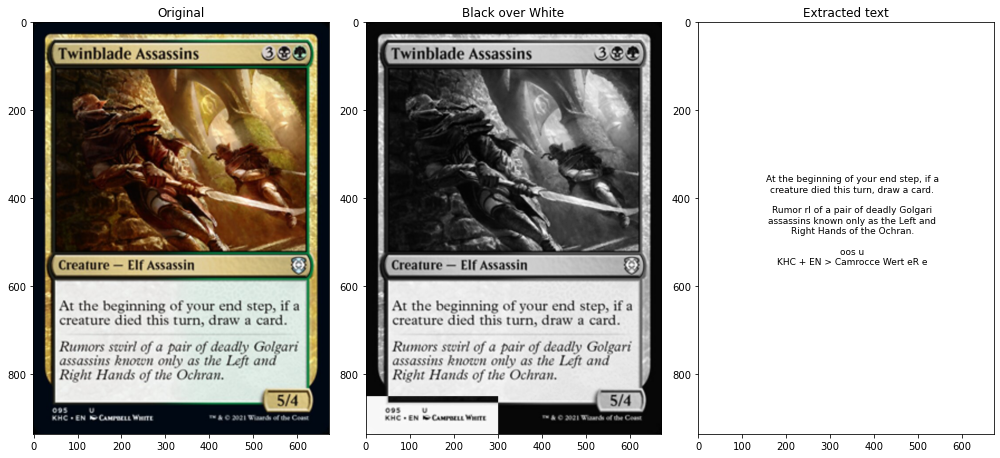

In [25]:
TEST_CASES = 1

for i in range(TEST_CASES):
    fig, ax = plt.subplots(1, 3, figsize=(14, 8), gridspec_kw={'width_ratios': [1, 1, 1]})
    
    # Pick a random card
    rnd_card = pick_random_card()
    while not 'paper' in rnd_card['availability']:
        rnd_card = pick_random_card()
     
    img = get_card_img(rnd_card)
    
    grayscale = black_over_white(img)

    tesseract_text = pytesseract.image_to_string(grayscale)
    tesseract_text = str.rstrip(tesseract_text)
    
    display_image(ax, img, grayscale, tesseract_text[:-2])
    
    ax[2].set_title("Extracted text")

fig.tight_layout()
plt.show()

## Indexing - Reverse search
Now that we can extract text from an image we are going to search corresponding card using the text extracted. To do that we first need to generate an index and a dictionary of the words available.

<img src="https://alexandria.works/wp-content/uploads/2020/01/Indexing-and-Query-Steps.png" alt="drawing" width="700"/>

### Index

In [45]:
import re

# The index is incapsulated in an object so that it's easier to save and load it without
# having to recalculate it each time
class Index:
    def __init__(self):
        self.index = {}
        self.cards = {}

    # Add keyword to the dictionary
    def add(self, card, card_id, keywords):
        if card_id not in self.cards:
            self.cards[card_id] = card

        for keyword in keywords:
            if len(keyword) > 3:
                if keyword not in self.index:
                    self.index[keyword] = set()

                self.index[keyword].add(card_id)    
    
    
    # Search functions
    def _results(self, query):
        if isinstance(query, str):
            return [self.index.get(query, set())]
        else:
            return [self.index.get(keyword, set()) for keyword in query]

    def search(self, query):
        # Provare a fare il ranking invece che con un punteggio sulle carte singole con
        # Il numer di insiemi in cui una parola chiave è presente
        results = self._results(query)
        cards = [self.cards[card_id] for card_id in set.intersection(*results)]
        return cards

    
    def ranked_search(self, query):
        results = self._results(query)
        ranking = dict.fromkeys( set.union(*results), 0)
        
        for result in results:
            for card_id in result:
                ranking[card_id] += 1 
            
        return ranking
        
    
    # Utility functions
    def standardize_keywords(self, text):
        std_text = text.lower()
        # 0-9+\/
        std_text = re.sub('[^a-z\s]+', '', std_text)
        std_text = re.sub('\n', ' ', std_text)

        keywords = set(std_text.split(' ') )
        keywords.discard('')

        return keywords
    
    
    def in_dictionary(self, keyword):
        if keyword in 'wizards of the coast'+'your mana pool':
           return False;
        if keyword in self.index.keys():
            return True
        else:
            return False
        
        
    def get_card(self, card_id):
        return self.index.get(keyword, set())

# -------------------------------------------------------------------
    
# Create object
index = Index()

# Add cards into the database
for ms in magic_sets:
    for card in magic_sets[ms]['cards']:
        if 'paper' in card['availability']:
            flavorText = card['flavorText'] if 'flavorText' in card else ''
            originalText = card['originalText'] if 'originalText' in card else ''
            text = card['text'] if 'text' in card else ''
            name = card['name'] if 'name' in card else ''
            flavorName = card['flavorName'] if 'flavorName' in card else ''
            card_type = card['type'] if 'type' in card else '' 
            artist = card['artist'] if 'artist' in card else ''

            all_text = flavorText+' '+ originalText+' '+ text+' '+ name+' '+\
                       flavorName+' '+ card_type + ' '+ artist;
            keywords = index.standardize_keywords(all_text)
            
            card_id = ms+'-'+card['number']
            
            index.add(card, card_id, keywords)

In [58]:
ranking = index.ranked_search({'step', 'creature', 'deadly', 'turn', 'card', 'only', 'hands', 'this', 'known', 'died', 'draw', 'beginning', 'rumor', 'assassins', 'ochran', 'pair', 'left', 'right', 'golgari'})
ranking

{'CON-106': 1,
 'TMP-211': 2,
 'ONS-120': 4,
 'DDQ-17': 1,
 'DDG-52': 1,
 'LEG-18': 2,
 'M15-174': 2,
 'PKLD-4s': 2,
 'PM19-149s': 2,
 'PM21-106s': 1,
 'TMP-41': 4,
 'MM2-236': 2,
 'CMD-202': 1,
 'TSR-119': 5,
 'APC-52': 3,
 'SOI-199': 3,
 'PRES-A12': 1,
 'USG-233': 1,
 'M10-68': 2,
 '2ED-187': 2,
 'CMR-215': 1,
 'MMA-18': 2,
 'MM3-146': 1,
 'MB1-467': 2,
 'DDH-48': 3,
 'DDK-21': 1,
 'MIR-163': 3,
 'ODY-131': 1,
 'DDK-33': 2,
 'M21-19': 2,
 'CMA-221': 3,
 'TSB-77': 2,
 'TSR-355': 1,
 'PARC-55': 2,
 '10E-289': 1,
 'GRN-20': 2,
 'CMR-574': 1,
 'C16-114': 1,
 'PLC-96': 4,
 'SOK-37': 3,
 'DGM-118': 2,
 'SOM-60': 2,
 'RIX-44': 1,
 '9ED-32': 2,
 'DDR-60': 4,
 'MRD-235': 1,
 'CHR-59': 3,
 'JVC-15': 4,
 'M11-184': 1,
 'MB1-107': 2,
 'JMP-318': 1,
 'DD2-13': 1,
 '5DN-161': 1,
 'APC-57': 2,
 'A25-35': 1,
 'EMN-139': 3,
 'UNH-97': 2,
 'GRN-102': 3,
 'PAVR-111': 1,
 'WAR-172': 2,
 'M21-292': 5,
 'A25-249': 4,
 'WC03-pk72sb': 2,
 'IKO-100': 4,
 'LEB-91': 3,
 'WC02-cr88': 1,
 'PTK-156': 1,
 'SHM-99'

In [57]:
len(index.index)
len(ranking)

43485

In [50]:
sorted(ranking, key=ranking.get, reverse=True)

['M21-226',
 'KHC-95',
 'C18-174',
 'CMR-78',
 'ALA-48',
 'CNS-44',
 'MB1-1414',
 '2XM-194',
 'CMR-104',
 'ALA-92',
 '5ED-39',
 'CMR-77',
 'ARB-33',
 'CMR-168',
 'UND-32',
 'ALA-168',
 'CMR-122',
 'MB1-662',
 '5ED-260',
 'PM21-45p',
 'JMP-17',
 'ICE-238',
 'MIR-8',
 'CMR-697',
 'ALA-103',
 'ALA-43',
 'CMR-267',
 'ALA-47',
 'ALA-120',
 'ALA-68',
 'CMR-626',
 'MH1-91',
 'CON-65',
 'M21-122',
 'XLN-225',
 'RIX-35',
 'PHJ-3',
 'MH1-153',
 'M21-330',
 'CON-44',
 'CMR-331',
 'ALL-73b',
 'SOI-195',
 'CMR-26',
 'ICE-141',
 'CMR-629',
 'SHM-176',
 'ALA-192',
 'CMR-525',
 'DDK-55',
 'ZNC-103',
 'CON-124',
 '5ED-329',
 'MM3-111',
 'DDN-18',
 'CMR-647',
 'CON-51',
 'CMR-654',
 'CMR-185',
 'BNG-149',
 'UST-84',
 'CON-21',
 'ALA-90',
 'UST-157',
 'PLS-18',
 'M21-45',
 'ALL-73a',
 'CMR-55',
 'CMR-636',
 'ALA-113',
 'JMP-18',
 'CMR-29',
 'CMR-587',
 'ALL-54',
 'ICE-271',
 'CON-46',
 'RAV-98',
 'CMR-121',
 'DDO-34',
 'INV-238',
 'M21-348',
 'ICE-212',
 'ARB-41',
 'PM21-45s',
 'CMR-50',
 'ALA-74',
 'MIR

In [31]:
# Add cards into the database
for ms in magic_sets:
    for card in magic_sets[ms]['cards']:
        if 'paper' in card['availability']:
            flavorText = card['flavorText'] if 'flavorText' in card else ''
            originalText = card['originalText'] if 'originalText' in card else ''
            text = card['text'] if 'text' in card else ''
            name = card['name'] if 'name' in card else ''
            flavorName = card['flavorName'] if 'flavorName' in card else ''
            card_type = card['type'] if 'type' in card else '' 
            artist = card['artist'] if 'artist' in card else ''

            all_text = flavorText+' '+ originalText+' '+ text+' '+ name+' '+\
                       flavorName+' '+ card_type + ' '+ artist;
            keywords = index.standardize_keywords(all_text)
            
            card_id = ms+'-'+card['number']
            
            index.add(card, card_id, keywords)

In [29]:
keywords = index.standardize_keywords(tesseract_text) 
for kwd in keywords.copy():
    if not index.in_dictionary(kwd):
        keywords.discard(kwd)

print("Keywords found: ", keywords, "\n")

res = index.search(keywords)


# Necessità di rimuovere due o più parole chiave
i = 0
while len(res) == 0:
    key_list = list(keywords)
    to_remove = key_list[i]
    key_list.remove( to_remove )
    res = index.search( key_list )
    i += 1
    if i == len(key_list)+1:
        break
    

if i > 0 and len(res) > 0:
    print("REMOVED WORD --> ",to_remove)
elif i>0:
    print("No match found")

print("Number of occurence found: ", len(res))
for i, r in enumerate(res):
    print("\n\n------------------------------ Occurence ", str(i+1), "------------------------------\n")
    print("Name:", r['name'])
    print("Set code:", r['setCode'])
    print("Rarity:", r['rarity'])
    print("Unique entries:")
    
    for entry in r:
        if not entry in ['foreignData', 'identifiers', 'uuid', 'variations']:
            unique = True

            for r2 in res:
                if not r == r2:
                    if (entry in r2) and (r[entry] == r2[entry]):
                        unique = False
            if unique:
                print("\t",entry, ":", r[entry])

Keywords found:  {'step', 'creature', 'deadly', 'turn', 'card', 'only', 'hands', 'this', 'known', 'died', 'draw', 'beginning', 'rumor', 'assassins', 'ochran', 'pair', 'left', 'right', 'golgari'} 

REMOVED WORD -->  rumor
Number of occurence found:  2


------------------------------ Occurence  1 ------------------------------

Name: Twinblade Assassins
Set code: KHC
Rarity: uncommon
Unique entries:
	 availability : ['paper']
	 flavorText : Rumors swirl of a pair of deadly Golgari assassins known only as the Left and Right Hands of the Ochran.
	 hasFoil : False
	 isReprint : True
	 isStarter : True
	 number : 95
	 purchaseUrls : {'cardKingdom': 'https://mtgjson.com/links/81b25ee9f718dbe9', 'tcgplayer': 'https://mtgjson.com/links/2532625ec9f50aea'}
	 setCode : KHC


------------------------------ Occurence  2 ------------------------------

Name: Twinblade Assassins
Set code: M21
Rarity: uncommon
Unique entries:
	 availability : ['arena', 'mtgo', 'paper']
	 flavorText : Rumors swirl of a

In [30]:
for i, r in enumerate(res):
    print("\n\n------------------------------ Occurence ", str(i+1), "------------------------------\n")
    print(r)



------------------------------ Occurence  1 ------------------------------

{'artist': 'Campbell White', 'availability': ['paper'], 'borderColor': 'black', 'colorIdentity': ['B', 'G'], 'colors': ['B', 'G'], 'convertedManaCost': 5.0, 'edhrecRank': 9460, 'flavorText': 'Rumors swirl of a pair of deadly Golgari assassins known only as the Left and Right Hands of the Ochran.', 'foreignData': [{'flavorText': 'Es kursieren Gerüchte über zwei tödliche Golgari-Attentäter, die nur als die linke und rechte Hand des Ochran bekannt sind.', 'language': 'German', 'multiverseId': 508488, 'name': 'Doppelklingenmeuchler', 'text': 'Zu Beginn deines Endsegments und falls in diesem Zug eine Kreatur gestorben ist, ziehe eine Karte.', 'type': 'Kreatur — Elf, Assassine'}, {'flavorText': 'Giran rumores en torno a una pareja de asesinos golgari conocidos como las Manos Izquierda y Derecha de los Ochran.', 'language': 'Spanish', 'multiverseId': 508591, 'name': 'Asesinos hojas gemelas', 'text': 'Al comienzo de 

## Known issue

### Wrong reads from tesseract

Sometimes Tesseract reads words that aren't in the card but present in the database.

<img src="https://i.ibb.co/QjFxVdY/download-3.png" alt="download-3" border="0">
<img src="https://i.ibb.co/X3Xsm8s/Screenshot-169.png" alt="Screenshot-169" border="0">

Solution: rank results instead of looking for an exact matches.

### Lands do no have much text on it
<img src="https://i.ibb.co/h2xbwRv/download-4.png" alt="download-4" border="0">
<img src="https://i.ibb.co/1Q9ddqd/Screenshot-170.png" alt="Screenshot-170" border="0">

Possible solutions:
- Categorize all the cards with few words as generic lands
- Search for patterns in the image (like the land symbols)

### Some cards do not have latin characters on it
<a href="https://ibb.co/1Rqyggs"><img src="https://i.ibb.co/XFs0QQy/download.png" alt="download" border="0"></a>
Possible solution:
- They are uncommon in Italy so ask to a real person is a strategy
- Look for the code in the bottom left corner and the artist
